# Configuration

In [3]:
img_width = 256
img_height = 256
input_channel = 26
output_channel = 1

# Imports

In [4]:
import os
import sys
import glob
import numpy as np
import pandas as pd
import random
import math
import gc
import cv2
from tqdm import tqdm
import time
from functools import lru_cache
import albumentations as A
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

In [5]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

In [6]:
def expand_contact_id(df):
    """
    Splits out contact_id into seperate columns.
    """
    df["game_play"] = df["contact_id"].str[:12]
    df["step"] = df["contact_id"].str.split("_").str[-3].astype("int")
    df["nfl_player_id_1"] = df["contact_id"].str.split("_").str[-2]
    df["nfl_player_id_2"] = df["contact_id"].str.split("_").str[-1]
    return df

In [7]:
base_path = "/kaggle/input/nfl-player-contact-detection/"
os.chdir(base_path)

labels_orig = expand_contact_id(pd.read_csv("train_labels.csv"))
print(len(labels_orig))
train_tracking_orig = pd.read_csv("train_player_tracking.csv")
print(len(train_tracking_orig))
train_helmets_orig = pd.read_csv("train_baseline_helmets.csv")
print(len(train_helmets_orig))
train_video_metadata_orig = pd.read_csv("train_video_metadata.csv")


4721618
1353053
3783616


In [8]:
labels = labels_orig
train_tracking = train_tracking_orig
train_helmets = train_helmets_orig
train_video_metadata = train_video_metadata_orig

#labels[["game_play", "contact"]].groupby("game_play").mean().sort_values("contact", ascending=False)
#lables.head

In [9]:
#plays = ['58204_002864']
plays = ['58168_003392','58172_003247','58173_003606',
         '58174_001792','58176_002844','58177_004239',
         '58180_000986','58180_004644','58187_001341',
         '58187_001383','58187_001691','58187_002329',
         '58187_002815'] 
train_video_metadata = train_video_metadata[train_video_metadata['game_play'].isin(plays)] 
print(train_video_metadata)

train_helmets = train_helmets[train_helmets['game_play'].isin(plays)] 
train_tracking = train_tracking[train_tracking['game_play'].isin(plays)] 
labels = labels[labels['game_play'].isin(plays)]

       game_play  game_key  play_id      view                start_time  \
0   58168_003392     58168     3392   Endzone  2020-09-11T03:01:43.134Z   
1   58168_003392     58168     3392  Sideline  2020-09-11T03:01:43.134Z   
2   58172_003247     58172     3247   Endzone  2020-09-13T19:30:42.414Z   
3   58172_003247     58172     3247  Sideline  2020-09-13T19:30:42.414Z   
4   58173_003606     58173     3606   Endzone  2020-09-13T19:45:07.527Z   
5   58173_003606     58173     3606  Sideline  2020-09-13T19:45:07.527Z   
6   58174_001792     58174     1792   Endzone  2020-09-13T18:11:38.532Z   
7   58174_001792     58174     1792  Sideline  2020-09-13T18:11:38.532Z   
8   58176_002844     58176     2844   Endzone  2020-09-13T19:10:15.684Z   
9   58176_002844     58176     2844  Sideline  2020-09-13T19:10:15.684Z   
10  58177_004239     58177     4239   Endzone  2020-09-13T20:09:11.307Z   
11  58177_004239     58177     4239  Sideline  2020-09-13T20:09:11.307Z   
12  58180_000986     5818

In [10]:
#!mkdir -p /content/nfl-frames-output

for video in tqdm(train_helmets.video.unique()):
    if 'Endzone2' not in video:
        !ffmpeg -i train/{video} -q:v 2 -f image2 /kaggle/working/{video}_%04d.jpg -hide_banner -loglevel error

  0%|          | 0/26 [00:00<?, ?it/s]

ffmpeg: /opt/conda/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /opt/conda/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)


  4%|▍         | 1/26 [00:04<02:01,  4.86s/it]

ffmpeg: /opt/conda/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /opt/conda/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)


  8%|▊         | 2/26 [00:09<01:49,  4.57s/it]

ffmpeg: /opt/conda/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /opt/conda/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)


 12%|█▏        | 3/26 [00:15<02:07,  5.52s/it]

ffmpeg: /opt/conda/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /opt/conda/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)


 15%|█▌        | 4/26 [00:22<02:11,  5.97s/it]

ffmpeg: /opt/conda/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /opt/conda/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)


 19%|█▉        | 5/26 [00:29<02:16,  6.49s/it]

ffmpeg: /opt/conda/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /opt/conda/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)


 23%|██▎       | 6/26 [00:37<02:15,  6.77s/it]

ffmpeg: /opt/conda/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /opt/conda/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)


 27%|██▋       | 7/26 [00:42<01:56,  6.13s/it]

ffmpeg: /opt/conda/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /opt/conda/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)


 31%|███       | 8/26 [00:46<01:40,  5.59s/it]

ffmpeg: /opt/conda/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /opt/conda/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)


 35%|███▍      | 9/26 [00:50<01:27,  5.12s/it]

ffmpeg: /opt/conda/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /opt/conda/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)


 38%|███▊      | 10/26 [00:54<01:17,  4.86s/it]

ffmpeg: /opt/conda/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /opt/conda/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)


 42%|████▏     | 11/26 [00:59<01:11,  4.76s/it]

ffmpeg: /opt/conda/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /opt/conda/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)


 46%|████▌     | 12/26 [01:03<01:04,  4.64s/it]

ffmpeg: /opt/conda/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /opt/conda/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)


 50%|█████     | 13/26 [01:09<01:04,  4.98s/it]

ffmpeg: /opt/conda/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /opt/conda/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)


 54%|█████▍    | 14/26 [01:15<01:03,  5.26s/it]

ffmpeg: /opt/conda/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /opt/conda/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)


 58%|█████▊    | 15/26 [01:19<00:52,  4.81s/it]

ffmpeg: /opt/conda/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /opt/conda/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)


 62%|██████▏   | 16/26 [01:22<00:44,  4.44s/it]

ffmpeg: /opt/conda/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /opt/conda/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)


 65%|██████▌   | 17/26 [01:27<00:40,  4.48s/it]

ffmpeg: /opt/conda/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /opt/conda/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)


 69%|██████▉   | 18/26 [01:31<00:36,  4.53s/it]

ffmpeg: /opt/conda/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /opt/conda/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)


 73%|███████▎  | 19/26 [01:37<00:34,  4.87s/it]

ffmpeg: /opt/conda/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /opt/conda/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)


 77%|███████▋  | 20/26 [01:43<00:30,  5.16s/it]

ffmpeg: /opt/conda/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /opt/conda/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)


 81%|████████  | 21/26 [01:49<00:26,  5.36s/it]

ffmpeg: /opt/conda/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /opt/conda/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)


 85%|████████▍ | 22/26 [01:55<00:22,  5.53s/it]

ffmpeg: /opt/conda/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /opt/conda/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)


 88%|████████▊ | 23/26 [01:59<00:15,  5.20s/it]

ffmpeg: /opt/conda/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /opt/conda/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)


 92%|█████████▏| 24/26 [02:04<00:09,  4.94s/it]

ffmpeg: /opt/conda/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /opt/conda/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)


 96%|█████████▌| 25/26 [02:09<00:05,  5.08s/it]

ffmpeg: /opt/conda/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /opt/conda/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)


100%|██████████| 26/26 [02:14<00:00,  5.19s/it]


In [11]:
# To create the features, they join the labelled data of players whether players are contacting each 
# other with the detailed tracking data of the direction and distance that they are travelling
#
# Algorithm for creating dataset
# ================================
# tr_tracking is the file train_player_tracking.csv which has a single row per player position
# df is train_labels.csv which contains a row for BOTH players and whether they are in contact with each other or the ground

# The feature dataset is a combination of both files, with the contact and tracking data all flattened into 1 row

# 1. Primary merge column is the step number in the video
# 2. They merge players into nfl_player_id_1 and nfl_player_id_2 based on the step and game_play that they are both in
# 3. They use clever merging to create _2 versions of each players tracking stats and add that to the dataframe
# 4. They square each x and y player location difference, sum it, and then square it again to creatre a distance column
# that is some kind of representation of both distances?

def create_features(df, tr_tracking, merge_col="step", use_cols=["x_position", "y_position"]):
    output_cols = []
    df_combo = (
        df.astype({"nfl_player_id_1": "str"})
        .merge(
            tr_tracking.astype({"nfl_player_id": "str"})[
                ["game_play", merge_col, "nfl_player_id",] + use_cols
            ],
            left_on=["game_play", merge_col, "nfl_player_id_1"],
            right_on=["game_play", merge_col, "nfl_player_id"],
            how="left",
        )
        .rename(columns={c: c+"_1" for c in use_cols})
        .drop("nfl_player_id", axis=1)
        .merge(
            tr_tracking.astype({"nfl_player_id": "str"})[
                ["game_play", merge_col, "nfl_player_id"] + use_cols
            ],
            left_on=["game_play", merge_col, "nfl_player_id_2"],
            right_on=["game_play", merge_col, "nfl_player_id"],
            how="left",
        )
        .drop("nfl_player_id", axis=1)
        .rename(columns={c: c+"_2" for c in use_cols})
        .sort_values(["game_play", merge_col, "nfl_player_id_1", "nfl_player_id_2"])
        .reset_index(drop=True)
    )
    output_cols += [c+"_1" for c in use_cols]
    output_cols += [c+"_2" for c in use_cols]
    
    if ("x_position" in use_cols) & ("y_position" in use_cols):
        index = df_combo['x_position_2'].notnull()
        
        distance_arr = np.full(len(index), np.nan)
        tmp_distance_arr = np.sqrt(
            np.square(df_combo.loc[index, "x_position_1"] - df_combo.loc[index, "x_position_2"])
            + np.square(df_combo.loc[index, "y_position_1"]- df_combo.loc[index, "y_position_2"])
        )
        
        distance_arr[index] = tmp_distance_arr
        df_combo['distance'] = distance_arr
        output_cols += ["distance"]
        
    df_combo['G_flug'] = (df_combo['nfl_player_id_2']=="G")
    output_cols += ["G_flug"]
    return df_combo, output_cols


use_cols = [
    'x_position', 'y_position', 'speed', 'distance',
    'direction', 'orientation', 'acceleration', 'sa'
]

train, feature_cols = create_features(labels, train_tracking, use_cols=use_cols)

In [12]:
# This section does some additional filtering
# First it removes any 'distance' values greater than 2 yards
# The distance is defined as => distance: distance traveled from prior time point, in yards.

# NOTE : From comments on one of the notebookas this was based on 
# They use a distance of 2 because "" distance <= 2, beacuse it can get recall 0.99+"
# see https://www.kaggle.com/code/zzy990106/nfl-2-5d-cnn-baseline-inference/comments#2071677

train_filtered = train.query('not distance>2').reset_index(drop=True)

# give the train more contact samples
#train_filtered = train_filtered.sort_values("contact", ascending=False).iloc[500:1000]
#train_filtered

# Then they convert the step value into a 'frame' number in the video and add that as a column
# 59.94 is average frame rate, 5*59.94 is because step=0 starts from 5s not 0s
train_filtered['frame'] = (train_filtered['step']/10*59.94+5*59.94).astype('int')+1
train_filtered.head()

,contact_id,game_play,datetime,step,nfl_player_id_1,nfl_player_id_2,contact,x_position_1,y_position_1,speed_1,...,y_position_2,speed_2,distance_2,direction_2,orientation_2,acceleration_2,sa_2,distance,G_flug,frame
0,58168_003392_0_37084_38567,58168_003392,2020-09-11T03:01:48.100Z,0,37084,38567,0,41.90,20.08,0.54,...,19.88,0.66,0.07,136.70,88.92,0.90,0.89,1.543017,False,300
1,58168_003392_0_37084_G,58168_003392,2020-09-11T03:01:48.100Z,0,37084,G,0,41.90,20.08,0.54,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,300
2,58168_003392_0_37211_46445,58168_003392,2020-09-11T03:01:48.100Z,0,37211,46445,0,39.59,17.07,0.53,...,18.08,1.10,0.10,148.93,92.39,2.03,2.03,1.258014,False,300
3,58168_003392_0_37211_G,58168_003392,2020-09-11T03:01:48.100Z,0,37211,G,0,39.59,17.07,0.53,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,300
4,58168_003392_0_38556_G,58168_003392,2020-09-11T03:01:48.100Z,0,38556,G,0,41.93,30.61,0.67,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,300


In [13]:
# I believe this to be an implementation of TTA
# https://www.kaggle.com/code/andrewkh/test-time-augmentation-tta-worth-it

# The image is flipped, transposed and contrast adjusted
train_aug = A.Compose([
    A.HorizontalFlip(p=0.75),
    A.ShiftScaleRotate(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.25),
    A.Normalize(mean=[0.], std=[1.])
])

valid_aug = A.Compose([
    A.Normalize(mean=[0.], std=[1.])
])


In [14]:
# This code creates a new lookup dataset called video2helmets which gives you all players that 
# are taking part in a particular play / video

video2helmets = {}
train_helmets_new = train_helmets.set_index('video')
for video in tqdm(train_helmets.video.unique()):
    video2helmets[video] = train_helmets_new.loc[video].reset_index(drop=True)

100%|██████████| 26/26 [00:00<00:00, 132.15it/s]


In [15]:
# This code creates a new lookup dataset called video2frames 
# which gives the number of frames that per video

video2frames = {}

for game_play in tqdm(train_video_metadata.game_play.unique()):
    for view in ['Endzone', 'Sideline']:
        video = game_play + f'_{view}.mp4'
        video2frames[video] = max(list(map(lambda x:int(x.split('_')[-1].split('.')[0]), \
                                           glob.glob(f'/kaggle/working/{video}*'))))

100%|██████████| 13/13 [00:00<00:00, 18.56it/s]


In [16]:
# This class now returns a single image per call
class TFDataset():
    def __init__(self, df, aug=train_aug, mode='train'):
        self.df = df
        self.frame = df.frame.values
        self.feature = df[feature_cols].fillna(-1).values
        self.players = df[['nfl_player_id_1','nfl_player_id_2']].values
        self.game_play = df.game_play.values
        self.aug = aug
        self.mode = mode
    
    def __len__(self):
        return len(self.df)
    
    # @lru_cache(1024)
    # def read_img(self, path):
    #     return cv2.imread(path, 0)
   
    def getitem(self):

        allIndexes = np.arange(len(self.df))
        #np.random.default_rng(seed).shuffle(allIndexes)

        for idx in allIndexes:

          #print("Idx : ", idx)
          #print("Idx : ", allIndexes)

          window = 24
          frame = self.frame[idx]
          
          if self.mode == 'train':
              frame = frame + random.randint(-6, 6)

          #print(self.players)

          players = []
          for p in self.players[idx]:
              #print("Number of players here : ", len(p))
              if p == 'G':
                  players.append(p)
              else:
                  players.append(int(p))
          
          imgs = []
          for view in ['Endzone', 'Sideline']:
              video = self.game_play[idx] + f'_{view}.mp4'

              tmp = video2helmets[video]
  #             tmp = tmp.query('@frame-@window<=frame<=@frame+@window')
              tmp[tmp['frame'].between(frame-window, frame+window)]
              tmp = tmp[tmp.nfl_player_id.isin(players)]#.sort_values(['nfl_player_id', 'frame'])
              tmp_frames = tmp.frame.values
              tmp = tmp.groupby('frame')[['left','width','top','height']].mean()
  #0.002s

              bboxes = []
              for f in range(frame-window, frame+window+1, 1):
                  if f in tmp_frames:
                      x, w, y, h = tmp.loc[f][['left','width','top','height']]
                      bboxes.append([x, w, y, h])
                  else:
                      bboxes.append([np.nan, np.nan, np.nan, np.nan])
              bboxes = pd.DataFrame(bboxes).interpolate(limit_direction='both').values
              bboxes = bboxes[::4]

              if bboxes.sum() > 0:
                  flag = 1
              else:
                  flag = 0
  #0.03s
                      
              for i, f in enumerate(range(frame-window, frame+window+1, 4)):
                  
                  #print("Pulling from %s frame window %d to %d (at iteration %d)" % (view ,frame-window,frame+window+1,i))
                  img_new = np.zeros((256, 256), dtype=np.float32)
                    
                  if flag == 1 and f <= video2frames[video]:
                      img = cv2.imread(f'/kaggle/working/{video}_{f:04d}.jpg', 0)
                      #print("Original")
                      #plt.imshow(img)
                      #plt.show()
                      x, w, y, h = bboxes[i]
                      img = img[int(y+h/2)-128:int(y+h/2)+128,int(x+w/2)-128:int(x+w/2)+128].copy()
                      #print("Zoomed")  
                      #plt.imshow(img)
                      #plt.show()
                      #plt.show()
                      #print("Image length is %s "  % (str(img.shape)))
                      img_new[:img.shape[0], :img.shape[1]] = img
                      #print("Image length is %s "  % (str(img_new.shape)))
                  #print("img type", type(img))
                  #print("img_new type", type(img))
                  #print("Pulling image ",len(img_new))
                  #plt.imshow(img.permute(1,2,0)[:,:,15])
                  #plt.imshow(img)
                  #plt.show()
   
                  imgs.append(img_new)
  #0.06s
                  
          feature = np.float32(self.feature[idx])
          
          #print("Pulled %s frame images in the window" % (len(imgs)))
          img = np.array(imgs).transpose(1, 2, 0)
          #plt.imshow(img[:,:,5])
          img = self.aug(image=img)["image"]
          #print("Now have %s images" % (str(img.shape)))
          label = np.float32(self.df.contact.values[idx])
          #print(type(img))
         # print(type(feature))
          #print(type(label))
          yield (img, feature), label


In [17]:
train_set,valid_set = train_test_split(train_filtered,test_size=0.05, random_state=42,stratify = train_filtered['contact'])

In [18]:
tfTrainData = TFDataset(train_set, train_aug, 'train')
tfValidData = TFDataset(valid_set, valid_aug, 'test')

dataset = tf.data.Dataset.from_generator(
    tfTrainData.getitem,
    args=[],
    output_signature=((
        tf.TensorSpec(shape=(256,256,input_channel), dtype=tf.float32),
        tf.TensorSpec(shape=(18,), dtype=tf.float32)),
        tf.TensorSpec(shape=(), dtype=tf.uint8)))

print(dataset.element_spec)

val_dataset = tf.data.Dataset.from_generator(
    tfValidData.getitem,
    args=[],
    output_signature=((
        tf.TensorSpec(shape=(256,256,input_channel), dtype=tf.float32),
        tf.TensorSpec(shape=(18,), dtype=tf.float32)),
        tf.TensorSpec(shape=(), dtype=tf.uint8)))

print(val_dataset.element_spec)


((TensorSpec(shape=(256, 256, 26), dtype=tf.float32, name=None), TensorSpec(shape=(18,), dtype=tf.float32, name=None)), TensorSpec(shape=(), dtype=tf.uint8, name=None))
((TensorSpec(shape=(256, 256, 26), dtype=tf.float32, name=None), TensorSpec(shape=(18,), dtype=tf.float32, name=None)), TensorSpec(shape=(), dtype=tf.uint8, name=None))


In [19]:
# import the necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import concatenate

def create_mlp(dim, regress=False):
    # define our MLP network
    model = Sequential()
    model.add(Dense(8, input_dim=dim, activation="relu"))
    model.add(Dense(4, activation="relu"))
    # check to see if the regression node should be added
    if regress:
        model.add(Dense(1, activation="linear"))
    # return our model
    return model

# ResNet50V2 Setup and Expansion to Super-channel (> 3 default)

In [20]:
def multify_weights(kernel, out_channels):
  mean_1d = np.mean(kernel, axis=-2).reshape(kernel[:,:,-1:,:].shape)
  tiled = np.tile(mean_1d, (out_channels, 1))
  return(tiled)


def weightify(model_orig, custom_model, layer_modify):
  layer_to_modify = [layer_modify]

  conf = custom_model.get_config()
  layer_names = [conf['layers'][x]['name'] for x in range(len(conf['layers']))]

  for layer in model_orig.layers:
    if layer.name in layer_names:
      if layer.get_weights() != []:
        target_layer = custom_model.get_layer(layer.name)

        if layer.name in layer_to_modify:    
          kernels = layer.get_weights()[0]
          biases  = layer.get_weights()[1]

          kernels_extra_channel = np.concatenate((kernels,
                                                  multify_weights(kernels, input_channel - 3)),
                                                  axis=-2) # For channels_last
                                                  
          target_layer.set_weights([kernels_extra_channel, biases])
          target_layer.trainable = False

        else:
          target_layer.set_weights(layer.get_weights())
          target_layer.trainable = False

In [21]:
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Dropout, MaxPooling2D, Conv2D, Conv2DTranspose, UpSampling2D, Dense
from tensorflow.keras.layers import Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras import backend as K
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout, MaxPooling2D, Conv2D, AveragePooling2D, LayerNormalization
from tensorflow.keras.layers import Conv2DTranspose, UpSampling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import LeakyReLU, ReLU


def get_resnet_v2_super_channel(pretrained_weights=None, input_size=(img_height, img_width, input_channel)):
    inputs = Input(input_size)
    resnet50 = ResNet50V2(weights='imagenet', include_top=False)
    print(type(resnet50))
    for layer in resnet50.layers:
      layer.trainable = False
    config = resnet50.get_config()
    config["layers"][0]["config"]["batch_input_shape"] = (None, img_width, img_height, input_channel)
    config["layers"][2]["config"]["strides"] = (1, 1)


    resnet_custom = tf.keras.Model.from_config(config)
    modify_name = config["layers"][2]["config"]["name"]


    weightify(resnet50, resnet_custom, modify_name)
    
    print(type(resnet50))
    return resnet_custom

In [22]:
model = get_resnet_v2_super_channel(input_size=(img_height, img_width, input_channel))

94668760/94668760 [==============================] - 3s 0us/step
<class 'keras.engine.functional.Functional'>
<class 'keras.engine.functional.Functional'>


In [23]:
def create_cnn(width, height, depth, filters=(16, 32, 64), regress=False):
    # initialize the input shape and channel dimension, assuming
    # TensorFlow/channels-last ordering
    inputShape = (height, width, depth)
    chanDim = -1
    # define the model input
    inputs = get_resnet_v2_super_channel(input_size=(img_height, img_width, input_channel)).input
    # loop over the number of filters
    for (i, f) in enumerate(filters):
        # if this is the first CONV layer then set the input
        # appropriately
        if i == 0:
            x = inputs
        # CONV => RELU => BN => POOL
        x = Conv2D(f, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
    # flatten the volume, then FC => RELU => BN => DROPOUT
    x = Flatten()(x)
    x = Dense(16)(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Dropout(0.5)(x)
    # apply another FC layer, this one to match the number of nodes
    # coming out of the MLP
    x = Dense(4)(x)
    x = Activation("relu")(x)
    # check to see if the regression node should be added
    if regress:
        x = Dense(1, activation="linear")(x)
    # construct the CNN
    model = Model(inputs, x)
    # return the CNN
    return model

In [24]:
# create the MLP and CNN models
mlp = create_mlp((18), regress=False)
cnn = create_cnn(256, 256, input_channel, regress=False)
# create the input to our final set of layers as the *output* of both
# the MLP and CNN
combinedInput = concatenate([mlp.output, cnn.output])
# our final FC layer head will have two dense layers, the final one
# being our regression head
x = Dense(4, activation="relu")(combinedInput)
x = Dense(1, activation="linear")(x)
# our final model will accept categorical/numerical data on the MLP
# input and images on the CNN input, outputting a single value (the
# predicted price of the house)
model_right = Model(inputs=[cnn.input, mlp.input], outputs=x)

<class 'keras.engine.functional.Functional'>
<class 'keras.engine.functional.Functional'>


<generator object TFDataset.getitem at 0x7f035e08c6d0>


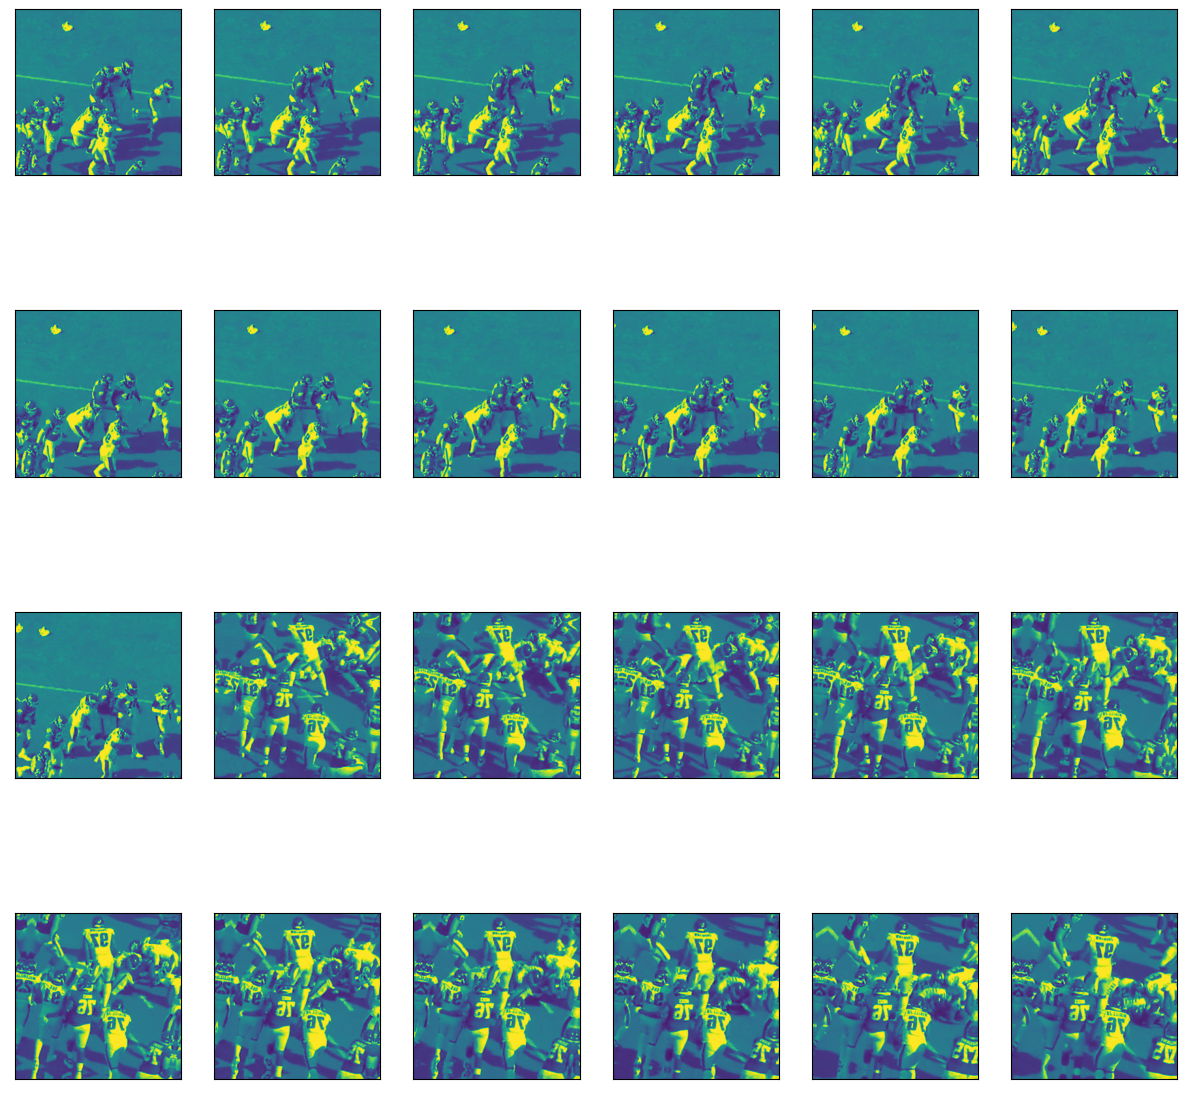

In [25]:
tfTrainData2 = TFDataset(train_set, train_aug, 'train')
seti = tfTrainData2.getitem()
print(seti)

import itertools
img_feature, label = next(itertools.islice(tfTrainData2.getitem(), 1))

#img, feature, label = tfTrainData2.getitem()

fig, ax_list = plt.subplots(4,6, figsize=(15, 15))

i = 0

for ax in ax_list.flatten():
    ax.imshow(img_feature[0][:,:,i])
    i = i + 1

for ax in ax_list.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

#for i in range(0,25):
#    plt.imshow(img[:,:,i])
#    plt.show()

#img.shape, feature, label

**ResNet50 Pyramid Pooling - Adding the extra channels**

In [26]:
model_right.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 2  0           []                               
                                6)]                                                               
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  3760        ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 activation (Activation)        (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                           

In [27]:
 model_right.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy']) 

In [28]:
history = model_right.fit(dataset.batch(50).prefetch(10),
                    epochs=3,
                    validation_data=val_dataset.batch(50).prefetch(10),
                    verbose=1)

Epoch 1/3
829/829 [==============================] - 8054s 10s/step - loss: 1.6202 - accuracy: 0.8950 - val_loss: 1.6196 - val_accuracy: 0.8950
Epoch 2/3
829/829 [==============================] - 7876s 9s/step - loss: 1.6202 - accuracy: 0.8950 - val_loss: 1.6196 - val_accuracy: 0.8950
Epoch 3/3
829/829 [==============================] - 7961s 10s/step - loss: 1.6202 - accuracy: 0.8950 - val_loss: 1.6196 - val_accuracy: 0.8950
